In [2]:
pip install python_speech_features

  Created wheel for python-speech-features: filename=python_speech_features-0.6-cp36-none-any.whl size=5887 sha256=786e65d597a9b3a10849ebba857324fe0969ee2d41e54bf287daa40ac2a8835b
  Stored in directory: /root/.cache/pip/wheels/3c/42/7c/f60e9d1b40015cd69b213ad90f7c18a9264cd745b9888134be
Successfully built python-speech-features


In [0]:
# -*- coding: utf-8 -*-

from keras.models import Model
from keras.layers import Input, Activation, Conv1D, Lambda, Add, Multiply, BatchNormalization
from keras.optimizers import Adam, SGD
#使得写出的代码兼容theano和tensorflow两种backend的代码
from keras import backend as K
#回调函数，该回调函数将在每个epoch后保存模型到filepath，当指标停止提升时，降低学习速率
#详细参考：https://keras-cn.readthedocs.io/en/latest/other/callbacks/
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
import random
#用于序列化
import pickle
#查找文件
import glob
#可视化程序进度
from tqdm import tqdm
#普遍的操作系统功能
import os
#音频特征提取
from python_speech_features import mfcc
#插值运算、优化算法、图像处理和数学统计等
import scipy.io.wavfile as wav
#音频的特征提取、谱图分解、谱图显示、顺序建模、创建音频等功能
import librosa
#显示声音，点击可播放，
from IPython.display import Audio
#另外如果你想播放mp3文件，音乐什么的
#from playsound import playsound 
#playsound(‘test.mp3’)

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import os
os.chdir('/content/gdrive/My Drive/NLP/Automatic_Speech_Recognition')

In [7]:
#因为文件太多，上传太慢，所以只使用了部分数据，文本标注文件
text_paths = glob.glob('data/*.trn')
total = len(text_paths)
print(total)
#对中文需要encoding='utf8'
with open(text_paths[0], 'r', encoding='utf8') as fr:
    lines = fr.readlines()
    print(lines)

83
['新 聘 国务院 参事 王 一平 新 聘 中央 文史 研究 馆 馆员 孙 机 程 毅 中 也 应邀 参加 了 招待会\n', 'xin1 pin4 guo2 wu4 yuan4 can1 shi4 wang2 yi4 ping2 xin1 pin4 zhong1 yang1 wen2 shi3 yan2 jiu1 guan3 guan3 yuan2 sun1 ji1 cheng2 yi4 zhong1 ye3 ying4 yao1 can1 jia1 le5 zhao1 dai4 hui4\n', 'x in1 p in4 g uo2 uu u4 vv van4 c an1 sh ix4 uu uang2 ii i4 p ing2 x in1 p in4 zh ong1 ii iang1 uu un2 sh ix3 ii ian2 j iu1 g uan3 g uan3 vv van2 s un1 j i1 ch eng2 ii i4 zh ong1 ii ie3 ii ing4 ii iao1 c an1 j ia1 l e5 zh ao1 d ai4 h ui4\n']


In [8]:
#提取文本标注和语音文件路径，保留中文并去掉空格
texts = []
paths = []
for path in text_paths:
  #只读取第一行中文
    with open(path, 'r', encoding='utf8') as fr:
        lines = fr.readlines()
        line = lines[0].strip('\n').replace(' ', '')
        texts.append(line)
        paths.append(path.rstrip('.trn'))

print(paths[0], texts[0])

data/B2_254.wav 新聘国务院参事王一平新聘中央文史研究馆馆员孙机程毅中也应邀参加了招待会


In [0]:
texts[1]

</br>获取MFCC的特征主要流程如下：</br>
预加重，分帧，加窗，快速傅里叶变换(FFT)，梅尔滤波器组，离散余弦变换(DCT).其中最重要的就是FFT和梅尔滤波器组，这两个进行了主要的将维操作。

Audio Text: 新聘国务院参事王一平新聘中央文史研究馆馆员孙机程毅中也应邀参加了招待会


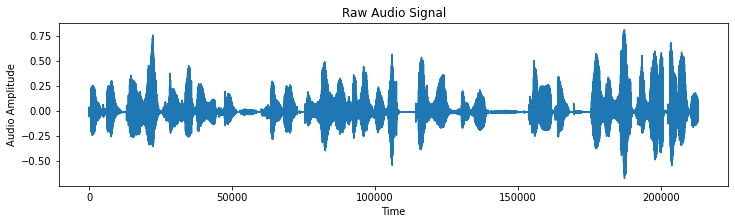

Shape of MFCC: (963, 13)


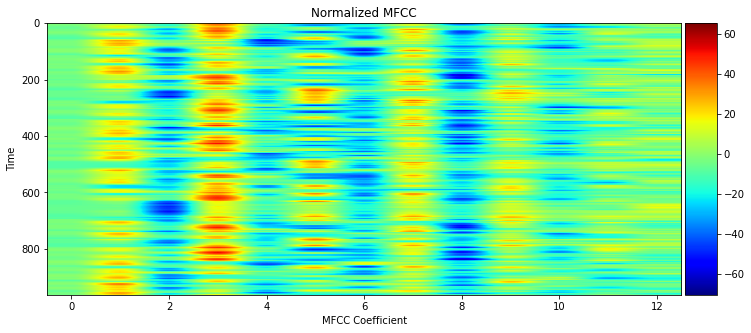

In [9]:
#MFCC特征保留13维，定义加载语音文件并去掉两端静音的函数，以及可视化语音文件的函数
mfcc_dim = 13

def load_and_trim(path):
  #返回语音的时间序列，以及y的采样率
    audio, sr = librosa.load(path)
    #根据音频样本y或声谱图S计算每帧的均方根（RMS）值。
    energy = librosa.feature.rmse(audio)
    # 函数返回输入数组中非零元素的索引，也即是满足均方根大于阈值的帧
    frames = np.nonzero(energy >= np.max(energy) / 5)
    #将帧索引转换为音频样本索引。
    indices = librosa.core.frames_to_samples(frames)[1]
    #音频的长度大于0的取音频时间序列的音频索引不包含最后一个点
    audio = audio[indices[0]:indices[-1]] if indices.size else audio[0:0]
    
    return audio, sr

def visualize(index):
    #音频文件位置
    path = paths[index]
    text = texts[index]
    print('Audio Text:', text)
    #原始Audio图像
    audio, sr = load_and_trim(path)
    plt.figure(figsize=(12, 3))
    plt.plot(np.arange(len(audio)), audio)
    plt.title('Raw Audio Signal')
    plt.xlabel('Time')
    plt.ylabel('Audio Amplitude')
    plt.show()
    #音频数据，采样频率，mfcc维度，傅里叶变换次数，最终得到音频特征
    feature = mfcc(audio, sr, numcep=mfcc_dim, nfft=551)
    #shape of MFCC
    print('Shape of MFCC:', feature.shape)
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(111)
    #cmap颜色图谱，jet代表蓝-青-黄-红，详细可见https://blog.csdn.net/haoji007/article/details/52063168
    im = ax.imshow(feature, cmap=plt.cm.jet, aspect='auto')
    plt.title('Normalized MFCC')
    plt.ylabel('Time')
    plt.xlabel('MFCC Coefficient')
    plt.colorbar(im, cax=make_axes_locatable(ax).append_axes('right', size='5%', pad=0.05))
    ax.set_xticks(np.arange(0, 13, 2), minor=False);
    plt.show()
    #
    return path
#Audio显示声音并可播放
Audio(visualize(0))

In [10]:
#获取全部语音文件对应的MFCC特征
features = []
for i in tqdm(range(total)):
    path = paths[i]
    audio, sr = load_and_trim(path)
    features.append(mfcc(audio, sr, numcep=mfcc_dim, nfft=551))
    
print(len(features), features[0].shape)

100%|██████████| 83/83 [01:22<00:00,  1.01it/s]

83 (963, 13)


In [11]:
#将MFCC特征进行标准化（所有），由于选择的数据量83小于100，因此直接用了83
#从列表里随机选择100个
samples = random.sample(features, 83)
#竖直堆叠序列中的数组
samples = np.vstack(samples)
#在列的方向上，从上往下计算所有行的平均值
mfcc_mean = np.mean(samples, axis=0)
#同理计算标准差
mfcc_std = np.std(samples, axis=0)
print(mfcc_mean)
print(mfcc_std)

features = [(feature - mfcc_mean) / (mfcc_std + 1e-14) for feature in features]

[ -4.15049038   4.49791465 -26.18490457  16.38647517 -20.28029446
   0.99834758 -21.0259477    9.10524891 -23.29595578   4.71886077
 -10.64949705  -2.38509233  -1.74860456]
[ 2.72972698 15.40205711 13.4632762  18.38291954 14.31687569 22.29463447
 16.30645892 15.02816754 14.40404311 14.43083758 12.4849974  11.80204263
  9.74412018]


In [12]:
#建立字典，共2883个不同的字
chars = {}
for text in texts:
    for c in text:
        chars[c] = chars.get(c, 0) + 1
#reverse使得按照出现次数从多到少排序，符合常理
chars = sorted(chars.items(), key=lambda x: x[1], reverse=True)
#得到中文字
chars = [char[0] for char in chars]
print(len(chars), chars[:100])
#中文字对应数字，这里使用最多的中文的字的下标为0，依次类推
char2id = {c: i for i, c in enumerate(chars)}
#数字对应中文字
id2char = {i: c for i, c in enumerate(chars)}

1047 ['的', '一', '在', '十', '人', '了', '年', '为', '不', '有', '国', '也', '要', '二', '是', '地', '我', '他', '中', '五', '大', '外', '与', '月', '而', '安', '区', '万', '九', '生', '军', '厂', '和', '能', '四', '公', '面', '来', '装', '上', '本', '文', '子', '等', '百', '业', '家', '着', '学', '们', '这', '法', '之', '参', '市', '因', '所', '个', '电', '化', '天', '里', '日', '于', '被', '好', '进', '千', '山', '成', '佛', '得', '平', '机', '工', '力', '到', '可', '夜', '已', '给', '两', '理', '产', '然', '省', '发', '以', '土', '俄', '药', '水', '羊', '品', '爱', '无', '高', '花', '民', '务']


In [13]:
id2char[0]

'的'

In [14]:
char2id['的']

0

In [0]:
#划分训练数据和测试数据，定义产生批数据的函数
data_index = np.arange(total)
#打乱数据
np.random.shuffle(data_index)
#随机抽取90%的数据作为训练数据集
train_size = int(0.9 * total)
#剩下的作为测试数据集
test_size = total - train_size

train_index = data_index[:train_size]
test_index = data_index[train_size:]
#训练数据集的特征数据，以及训练数据集的标签文字数据
X_train = [features[i] for i in train_index]
Y_train = [texts[i] for i in train_index]
#
X_test = [features[i] for i in test_index]
Y_test = [texts[i] for i in test_index]
#批次大小,数据量小，因此batch也小否则会报错，自己数据量大时可以设置为16，32，64...
batch_size = 5
    
def batch_generator(x, y, batch_size=batch_size):  
    offset = 0
    while True:
        offset += batch_size
        #如果等于批次大小或者批次大小超过训练集的长度
        if offset == batch_size or offset >= len(x):
            #在训练集长度里
            data_index = np.arange(len(x))
            #在将训练集长度里的下标打乱
            np.random.shuffle(data_index)
            x = [x[i] for i in data_index]
            y = [y[i] for i in data_index]
            offset = batch_size
        #取batch大小的数据集，第一个从0-16，下一个则为   
        X_data = x[offset - batch_size: offset]
        Y_data = y[offset - batch_size: offset]
        #特征最大长度某一维里选一个都一样，文字最大长度
        X_maxlen = max([X_data[i].shape[0] for i in range(batch_size)])
        Y_maxlen = max([len(Y_data[i]) for i in range(batch_size)])
        #16 x 特征最大长度 x 13的0矩阵
        X_batch = np.zeros([batch_size, X_maxlen, mfcc_dim])
        #产生汉字个数例如2883个16x文字最大长度的全为1的矩阵
        Y_batch = np.ones([batch_size, Y_maxlen]) * len(char2id)
        X_length = np.zeros([batch_size, 1], dtype='int32')
        Y_length = np.zeros([batch_size, 1], dtype='int32')
        
        for i in range(batch_size):
            X_length[i, 0] = X_data[i].shape[0]
            #产生特征的批数据
            X_batch[i, :X_length[i, 0], :] = X_data[i]
            #记录批次里各个句子的长度
            Y_length[i, 0] = len(Y_data[i])
            #将各个中文字对应的数字加入到一个批次里对应的句子里，比最大句子长度短的句子里，有的位置则是0
            Y_batch[i, :Y_length[i, 0]] = [char2id[c] for c in Y_data[i]]
        
        inputs = {'X': X_batch, 'Y': Y_batch, 'X_length': X_length, 'Y_length': Y_length}
        outputs = {'ctc': np.zeros([batch_size])}
        #迭代器，依次产生一个batch的数据，也即在这里终端循环
        yield (inputs, outputs)

In [21]:
#定义训练参数和模型结构并开始训练
epochs = 50
num_blocks = 3
filters = 128
#mfcc_dim=13
X = Input(shape=(None, mfcc_dim,), dtype='float32', name='X')
Y = Input(shape=(None,), dtype='float32', name='Y')
X_length = Input(shape=(1,), dtype='int32', name='X_length')
Y_length = Input(shape=(1,), dtype='int32', name='Y_length')
#因为是一维的时序数据，因此使用conv1d
def conv1d(inputs, filters, kernel_size, dilation_rate):
    return Conv1D(filters=filters, kernel_size=kernel_size, strides=1, padding='causal', activation=None, dilation_rate=dilation_rate)(inputs)
#批正则化，除此之外还有layerNormalization,instanceNormalization
def batchnorm(inputs):
    return BatchNormalization()(inputs)
#激活函数
def activation(inputs, activation):
    return Activation(activation)(inputs)
#定义跳跃层residual
def res_block(inputs, filters, kernel_size, dilation_rate):
    #hf层，卷积之后接批正则化然后接tanh激活函数
    hf = activation(batchnorm(conv1d(inputs, filters, kernel_size, dilation_rate)), 'tanh')
    #hg层，卷积之后接批标准化接sigmoid激活函数
    hg = activation(batchnorm(conv1d(inputs, filters, kernel_size, dilation_rate)), 'sigmoid')
    #两层的输出相乘
    h0 = Multiply()([hf, hg])
    #和上面相同
    ha = activation(batchnorm(conv1d(h0, filters, 1, 1)), 'tanh')
    hs = activation(batchnorm(conv1d(h0, filters, 1, 1)), 'tanh')
    #这里是相加
    return Add()([ha, inputs]), hs
#直接对输入进行卷积得到h0
h0 = activation(batchnorm(conv1d(X, filters, 1, 1)), 'tanh')
shortcut = []
for i in range(num_blocks):
  #p膨胀系数
    for r in [1, 2, 4, 8, 16]:
      #将直接卷积得到的h0作为输入，进入res层，并且每次都会得到h0作为下一次的输入
        h0, s = res_block(h0, filters, 7, r)
        shortcut.append(s)

h1 = activation(Add()(shortcut), 'relu')

h1 = activation(batchnorm(conv1d(h1, filters, 1, 1)), 'relu')

Y_pred = activation(batchnorm(conv1d(h1, len(char2id) + 1, 1, 1)), 'softmax')

sub_model = Model(inputs=X, outputs=Y_pred)
#定义损失函数
def calc_ctc_loss(args):
    y, yp, ypl, yl = args
    return K.ctc_batch_cost(y, yp, ypl, yl)
#计算损失，相当于损失层
ctc_loss = Lambda(calc_ctc_loss, output_shape=(1,), name='ctc')([Y, Y_pred, X_length, Y_length])
model = Model(inputs=[X, Y, X_length, Y_length], outputs=ctc_loss)
optimizer = SGD(lr=0.02, momentum=0.9, nesterov=True, clipnorm=5)
#将损失函数和优化器组合起来
model.compile(loss={'ctc': lambda ctc_true, ctc_pred: ctc_pred}, optimizer=optimizer)

checkpointer = ModelCheckpoint(filepath='asr.h5', verbose=0)
#学习率
lr_decay = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=1, min_lr=0.000)

history = model.fit_generator(
    generator=batch_generator(X_train, Y_train), 
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs, 
    validation_data=batch_generator(X_test, Y_test), 
    validation_steps=len(X_test) // batch_size, 
    callbacks=[checkpointer, lr_decay])

Epoch 1/50
14/14 [==============================] - 34s 2s/step - loss: 4792.7711 - val_loss: 3858.5337
Epoch 2/50
14/14 [==============================] - 5s 345ms/step - loss: 2252.3518 - val_loss: 1867.0162
Epoch 3/50
14/14 [==============================] - 4s 262ms/step - loss: 333.7628 - val_loss: 1624.4148
Epoch 4/50
14/14 [==============================] - 5s 355ms/step - loss: 264.3543 - val_loss: 850.0109
Epoch 5/50
14/14 [==============================] - 3s 213ms/step - loss: 231.7998 - val_loss: 586.6718
Epoch 6/50
14/14 [==============================] - 4s 267ms/step - loss: 223.9524 - val_loss: 516.5101
Epoch 7/50
14/14 [==============================] - 4s 252ms/step - loss: 216.4083 - val_loss: 335.5278
Epoch 8/50
14/14 [==============================] - 3s 215ms/step - loss: 207.2921 - val_loss: 239.7039
Epoch 9/50
14/14 [==============================] - 3s 205ms/step - loss: 195.2635 - val_loss: 228.9225
Epoch 10/50
14/14 [==============================] - 3s 202ms

In [0]:
#保存模型和字典
sub_model.save('asr.h5')
with open('dictionary.pkl', 'wb') as fw:
    pickle.dump([char2id, id2char, mfcc_mean, mfcc_std], fw)

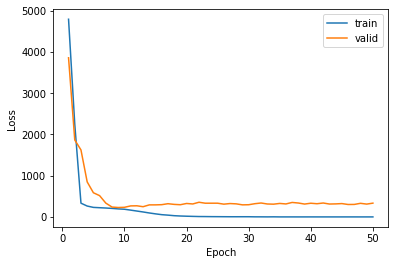

In [23]:
#绘制训练过程中的损失函数曲线
train_loss = history.history['loss']
valid_loss = history.history['val_loss']
plt.plot(np.linspace(1, epochs, epochs), train_loss, label='train')
plt.plot(np.linspace(1, epochs, epochs), valid_loss, label='valid')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [24]:
#加载模型，随机对训练集和测试集中的语音进行识别
from keras.models import load_model
import pickle

with open('dictionary.pkl', 'rb') as fr:
    [char2id, id2char, mfcc_mean, mfcc_std] = pickle.load(fr)

sub_model = load_model('asr.h5')

def random_predict(x, y):
    index = np.random.randint(len(x))
    feature = x[index]
    text = y[index]
    
    pred = sub_model.predict(np.expand_dims(feature, axis=0))
    pred_ids = K.eval(K.ctc_decode(pred, [feature.shape[0]], greedy=False, beam_width=10, top_paths=1)[0][0])
    pred_ids = pred_ids.flatten().tolist()
    
    print('True transcription:\n-- ', text, '\n')
    print('Predicted transcription:\n-- ' + ''.join([id2char[i] for i in pred_ids]), '\n')

random_predict(X_train, Y_train)
random_predict(X_test, Y_test)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


True transcription:
--  新聘国务院参事王一平新聘中央文史研究馆馆员孙机程毅中也应邀参加了招待会 

Predicted transcription:
-- 新聘国务院参事王一平新聘中央文史研究馆馆员孙机程毅中也应邀参加了招待会 

True transcription:
--  碰上爱玩且能玩物成痴玩物成癖的人总能令人愉快地会心一笑 

Predicted transcription:
-- 也一代贩 

